# Análise preditiva dos jogos do Brasileirão

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

2023-12-18 01:21:01.887690: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 01:21:02.411171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 01:21:02.411273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 01:21:02.516575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 01:21:02.728201: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 01:21:02.730909: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Load data

In [2]:
# Histórico de partidas - brasileirao 2003 a 2020
hist_jogos = pd.read_csv("Datasets/Brasileirao/campeonato-brasileiro-pontos-corridos-2003-2020-jogos.csv", sep=";")

# Dados de idade e economico, por time participante, por ano
hist_valores = pd.read_excel("/home/rodrigogsvaz/Datasets/Brasileirao/Dados.xlsx", "Dados idade, valor")

# Histórico recente de conquistas
hist_conquistas = pd.read_excel("/home/rodrigogsvaz/Datasets/Brasileirao/Dados.xlsx", "Historico ano anterior")


### Treat data and add new features

hist_jogos

In [3]:
# Cria possíveis targets

def f_resultado(df):
    if df["Mandante Placar"] > df["Visitante Placar"]:
        return "vitoria"
    elif df["Mandante Placar"] == df["Visitante Placar"]:
        return "empate"
    elif df["Mandante Placar"] < df["Visitante Placar"]:
        return "derrota"
    
def f_vitoria(df):
    if df["Mandante Placar"] > df["Visitante Placar"]:
        return 1
    else:
        return 0
    
hist_jogos["resultado_mandante"] = hist_jogos.apply(f_resultado, axis=1)
hist_jogos["vitoria_mandante"] = hist_jogos.apply(f_vitoria, axis=1)

In [4]:
# Indica se mesmo estado
hist_jogos["mesmo_estado"] = hist_jogos.apply(lambda x: 1 if x["Estado Mandante"] == x["Estado Visitante"] else 0, axis = 1)


# Indica se mesma região
sul = ["PR", "RS", "SC"]
sudeste = ["ES", "MG", "SP", "RJ"]
centro_oeste = ["GO", "MT", "MS", "DF"]
nordeste = ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"]
norte = ["AC", "AP", "AM", "PA", "RO", "RR", "TO"]

def f_classifica_regiao(estado):
    if estado in sul:
        return "sul"
    elif estado in sudeste:
        return "sudeste"
    elif estado in centro_oeste:
        return "centro_oeste"
    elif estado in nordeste:
        return "nordeste"
    elif estado in norte:
        return "norte"
    


hist_jogos["regiao_mandante"] = hist_jogos["Estado Mandante"].apply(lambda x: f_classifica_regiao(x))
hist_jogos["regiao_visitante"] = hist_jogos["Estado Visitante"].apply(lambda x: f_classifica_regiao(x))


hist_jogos["mesma_regiao"] = hist_jogos.apply(lambda x: 1 if x["regiao_mandante"] == x["regiao_visitante"] else 0, axis = 1)


In [5]:
# Deixa o ano explícito
hist_jogos['data'] = pd.to_datetime(hist_jogos['Data'], format='%d/%m/%Y')
hist_jogos['ano'] = hist_jogos['data'].apply(lambda x: x.year)

# Pega só o mais importante
columns = ["ano",
           "Rodada", 
           "Dia",
           "Horário",
           "Mandante",
           "Visitante",
           "mesmo_estado",
           "mesma_regiao",
           "resultado_mandante",
           "vitoria_mandante"]

hist_jogos = hist_jogos.loc[:, columns]

hist_valores

In [6]:
hist_valores.valor_de_mercado_medio.replace({' €':''}, regex=True, inplace=True)
hist_valores.valor_de_mercado_total.replace({' €':''}, regex=True, inplace=True)

def f_multiplica_valor(x):
    if "mi." in x:
        return 1000000
    elif "mil" in x:
        return 1000

hist_valores["valor_de_mercado_medio_aux"] = hist_valores["valor_de_mercado_medio"].apply(f_multiplica_valor)
hist_valores["valor_de_mercado_total_aux"] = hist_valores["valor_de_mercado_total"].apply(f_multiplica_valor)

hist_valores.valor_de_mercado_medio.replace({' mi.':''}, regex=True, inplace=True)
hist_valores.valor_de_mercado_total.replace({' mi.':''}, regex=True, inplace=True)

hist_valores.valor_de_mercado_medio.replace({' mil':''}, regex=True, inplace=True)
hist_valores.valor_de_mercado_total.replace({' mil':''}, regex=True, inplace=True)

hist_valores.valor_de_mercado_medio.replace({',':'.'}, regex=True, inplace=True)
hist_valores.valor_de_mercado_total.replace({',':'.'}, regex=True, inplace=True)

In [7]:
hist_valores["valor_de_mercado_medio"] = hist_valores["valor_de_mercado_medio"].astype("float")
hist_valores["valor_de_mercado_total"] = hist_valores["valor_de_mercado_total"].astype("float")

In [8]:
hist_valores["valor_de_mercado_medio"] = hist_valores["valor_de_mercado_medio"] * hist_valores["valor_de_mercado_medio_aux"]
hist_valores["valor_de_mercado_total"] = hist_valores["valor_de_mercado_total"] * hist_valores["valor_de_mercado_total_aux"]

In [9]:
hist_valores = hist_valores.rename(columns={"valor_de_mercado_medio":"valor_de_mercado_medio_euros",
                                            "valor_de_mercado_total":"valor_de_mercado_total_euros"})

In [10]:
# Pega só o mais importante
columns = ["ano", 
           "clube", 
           "plantel", 
           "idade_media", 
           "estrangeiros", 
           "valor_de_mercado_medio_euros", 
           "valor_de_mercado_total_euros"]

hist_valores = hist_valores.loc[:, columns]

hist_conquistas

In [11]:
#Indica se houve título no ano anterior
def f_titulos(df):
    if (df["campeao_brasileirao_ano_anterior"] + 
        df["campeao_copa_do_brasil_ano_anterior"] + 
        df["campeao_sul_americana_ano_anterior"] + 
        df["campeao_libertadores_ano_anterior"]) >= 1:
        return 1
    else:
        return 0

hist_conquistas["titulo_ano_anterior"] = hist_conquistas.apply(f_titulos, axis=1)

In [12]:
#Indica se houve título ou G4 no ano anterior ---> Joga libertadores

def f_deve_jogar_libertadores(df):
    if (df["campeao_brasileirao_ano_anterior"] + 
        df["campeao_copa_do_brasil_ano_anterior"] + 
        df["campeao_sul_americana_ano_anterior"] + 
        df["campeao_libertadores_ano_anterior"]) >= 1:
        return 1
    elif df["posicao_brasileirao_ano_anterior"] <= 4:
        return 1
    else:
        return 0

hist_conquistas["posicao_brasileirao_ano_anterior"] = hist_conquistas["posicao_brasileirao_ano_anterior"].astype("int")
hist_conquistas["jogando_libertadores"] = hist_conquistas.apply(f_deve_jogar_libertadores, axis=1)

In [13]:
# Pega só o mais importante
columns = ["ano",
           "posicao_brasileirao_ano_anterior", 
           "clube", 
           "saldo_de_gols_ano_anterior", 
           "pontos", 
           "campeao_brasileirao_ano_anterior", 
           "campeao_copa_do_brasil_ano_anterior", 
           "campeao_sul_americana_ano_anterior",
           "campeao_libertadores_ano_anterior",
           "titulo_ano_anterior",
           "jogando_libertadores"]

hist_conquistas = hist_conquistas.loc[:, columns]

Padroniza as bases e junta tudo

In [14]:
# Padroniza nomes dos times

def f_padroniza_nome_times(df):
  df = df.replace(['Athlético-PR', 'Athletico Paranaense', 'Clube Atlético Paranaense'], 'Athlético-PR')
  df = df.replace(['Guarani', 'Guarani FC'], 'Guarani')
  df = df.replace(['Fortaleza', 'Fortaleza EC'], 'Fortaleza')
  df = df.replace(['Flamengo', 'FLAMENGO', 'CR Flamengo', 'CR Flamengo\xa0'], 'Flamengo')
  df = df.replace(['Vitória', 'EC Vitória'], 'Vitória')
  df = df.replace(['Santos', 'SANTOS', 'Santos FC'], 'Santos')
  df = df.replace(['Goiás', 'Goiás EC', ''], 'Goiás')
  df = df.replace(['Internacional', 'SC Internacional'], 'Internacional')
  df = df.replace(['Cruzeiro', 'CRUZEIRO'], 'Cruzeiro EC')
  df = df.replace(['Juventude', 'EC Juventude'], 'Juventude')
  df = df.replace(['Corinthians', 'CORINTHIANS', 'SC Corinthians'], 'Corinthians')
  df = df.replace(['Criciúma', 'Criciúma EC'], 'Criciúma')
  df = df.replace(['Fluminense', 'FLUMINENSE', 'Fluminense FC'], 'Fluminense')
  df = df.replace(['Atlético-MG', 'Atlético Mineiro', ''], 'Atlético-MG')
  df = df.replace(['Grêmio', 'Grêmio FBPA'], 'Grêmio')
  df = df.replace(['Coritiba', 'Coritiba FC', ''], 'Coritiba')
  df = df.replace(['Figueirense', 'Figueirense FC'], 'Figueirense')
  df = df.replace(['São Paulo', 'São Paulo FC', 'São Paulo FC\xa0'], 'São Paulo')
  df = df.replace(['Bahia', 'EC Bahia', ''], 'Bahia')
  df = df.replace(['Paraná', 'Paraná Clube'], 'Paraná')
  df = df.replace(['Ponte Preta', 'AA Ponte Preta'], 'Ponte Preta')
  df = df.replace(['São Caetano'], 'São Caetano')
  df = df.replace(['Vasco', 'CR Vasco da Gama', 'VASCO'], 'Vasco')
  df = df.replace(['Paysandu'], 'Paysandu')
  df = df.replace(['Palmeiras', 'SE Palmeiras', 'SE Palmeiras\xa0'], 'Palmeiras')
  df = df.replace(['Botafogo-RJ', 'Botafogo-rj', 'Botafogo FR'], 'Botafogo-RJ')
  df = df.replace(['Brasiliense'], 'Brasiliense')
  df = df.replace(['Santa Cruz', 'Santa Cruz FC'], 'Santa Cruz')
  df = df.replace(['Sport', 'Sport Recife'], 'Sport')
  df = df.replace(['América-RN'], 'América-RN')
  df = df.replace(['Náutico'], 'Náutico')
  df = df.replace(['Portuguesa'], 'Portuguesa')
  df = df.replace(['Ipatinga'], 'Ipatinga')
  df = df.replace(['Avaí', 'Avaí FC'], 'Avaí')
  df = df.replace(['Santo André', 'EC Santo André'], 'Santo André')
  df = df.replace(['Barueri', 'Grêmio Barueri Futebol Ltda.'], 'Barueri')
  df = df.replace(['Atlético-GO', 'Atlético Goianiense'], 'Atlético-GO')
  df = df.replace(['Ceará', 'Ceará SC'], 'Ceará')
  df = df.replace(['Grêmio Prudente'], 'Grêmio Prudente')
  df = df.replace(['América-MG', 'América Mineiro'], 'América-MG')
  df = df.replace(['Chapecoense'], 'Chapecoense')
  df = df.replace(['Joinville', 'Joinville EC'], 'Joinville')
  df = df.replace(['CSA'], 'CSA')
  df = df.replace(['Bragantino', 'RB Bragantino'], 'Bragantino')
  df = df.replace(['Cuiabá EC'], 'Cuiabá EC')

  return df


hist_jogos = f_padroniza_nome_times(hist_jogos)
hist_valores = f_padroniza_nome_times(hist_valores)
hist_conquistas = f_padroniza_nome_times(hist_conquistas)

In [15]:
df = hist_jogos.copy()

In [16]:
df = pd.merge(df, hist_valores, left_on=["ano", "Mandante"], right_on=["ano", "clube"], how="left")

df = df.rename(columns={"clube":"clube_mandante",
                        "plantel":"plantel_mandante",
                        "idade_media":"idade_media_mandante",
                        "estrangeiros":"estrangeiros_mandante",
                        "valor_de_mercado_medio_euros":"valor_de_mercado_medio_euros_mandante",
                        "valor_de_mercado_total_euros":"valor_de_mercado_total_euros_mandante"})

In [17]:
df = pd.merge(df, hist_valores, left_on=["ano", "Visitante"], right_on=["ano", "clube"], how="left")

df = df.rename(columns={"clube":"clube_visitante",
                        "plantel":"plantel_visitante",
                        "idade_media":"idade_media_visitante",
                        "estrangeiros":"estrangeiros_visitante",
                        "valor_de_mercado_medio_euros":"valor_de_mercado_medio_euros_visitante",
                        "valor_de_mercado_total_euros":"valor_de_mercado_total_euros_visitante"})

In [18]:
df = pd.merge(df, hist_conquistas, left_on=["ano", "Mandante"], right_on=["ano", "clube"], how="left")

df = df.rename(columns={"clube":"clube_mandante",
                        "posicao_brasileirao_ano_anterior":"posicao_brasileirao_ano_anterior_mandante",
                        "saldo_de_gols_ano_anterior":"saldo_de_gols_ano_anterior_mandante",
                        "pontos":"pontos_mandante",
                        "campeao_brasileirao_ano_anterior":"campeao_brasileirao_ano_anterior_mandante",
                        "campeao_copa_do_brasil_ano_anterior":"campeao_copa_do_brasil_ano_anterior_mandante",
                        "campeao_sul_americana_ano_anterior":"campeao_sul_americana_ano_anterior_mandante",
                        "campeao_libertadores_ano_anterior":"campeao_libertadores_ano_anterior_mandante",
                        "titulo_ano_anterior":"titulo_ano_anterior_mandante",
                        "jogando_libertadores":"jogando_libertadores_mandante"
                        })

In [19]:
df = pd.merge(df, hist_conquistas, left_on=["ano", "Visitante"], right_on=["ano", "clube"], how="left")

df = df.rename(columns={"clube":"clube_visitante",
                        "posicao_brasileirao_ano_anterior":"posicao_brasileirao_ano_anterior_visitante",
                        "saldo_de_gols_ano_anterior":"saldo_de_gols_ano_anterior_visitante",
                        "pontos":"pontos_visitante",
                        "campeao_brasileirao_ano_anterior":"campeao_brasileirao_ano_anterior_visitante",
                        "campeao_copa_do_brasil_ano_anterior":"campeao_copa_do_brasil_ano_anterior_visitante",
                        "campeao_sul_americana_ano_anterior":"campeao_sul_americana_ano_anterior_visitante",
                        "campeao_libertadores_ano_anterior":"campeao_libertadores_ano_anterior_visitante",
                        "titulo_ano_anterior":"titulo_ano_anterior_visitante",
                        "jogando_libertadores":"jogando_libertadores_visitante"
                        })

In [20]:
# Filtra apenas os anos que tem info de tudo (2010 a 2020)
df = df[(df.ano >= 2010) & (df.ano <= 2020)]

In [21]:
# Filtragem de colunas

columns = ["ano",
           'Rodada', 
           'Dia', 
           'Horário', 
           'mesmo_estado', 
           'mesma_regiao', 
           'resultado_mandante',
           'vitoria_mandante', 
           'plantel_mandante',
           'idade_media_mandante', 
           'estrangeiros_mandante',
           'valor_de_mercado_medio_euros_mandante',
           'valor_de_mercado_total_euros_mandante',
           'plantel_visitante', 
           'idade_media_visitante', 
           'estrangeiros_visitante',
           'valor_de_mercado_medio_euros_visitante',
           'valor_de_mercado_total_euros_visitante',
           'posicao_brasileirao_ano_anterior_mandante', 
           'saldo_de_gols_ano_anterior_mandante', 
           'pontos_mandante',
           'campeao_brasileirao_ano_anterior_mandante',
           'campeao_copa_do_brasil_ano_anterior_mandante',
           'campeao_sul_americana_ano_anterior_mandante',
           'campeao_libertadores_ano_anterior_mandante',
           'titulo_ano_anterior_mandante', 
           'jogando_libertadores_mandante',
           'posicao_brasileirao_ano_anterior_visitante', 
           'clube_visitante',
           'saldo_de_gols_ano_anterior_visitante', 
           'pontos_visitante',
           'campeao_brasileirao_ano_anterior_visitante',
           'campeao_copa_do_brasil_ano_anterior_visitante',
           'campeao_sul_americana_ano_anterior_visitante',
           'campeao_libertadores_ano_anterior_visitante',
           'titulo_ano_anterior_visitante', 
           'jogando_libertadores_visitante']

df = df.loc[:, columns]

### Feature Engineering

In [22]:
# Preenche infos faltantes
df["campeao_brasileirao_ano_anterior_mandante"] = df["campeao_brasileirao_ano_anterior_mandante"].fillna(0)
df["campeao_copa_do_brasil_ano_anterior_mandante"] = df["campeao_copa_do_brasil_ano_anterior_mandante"].fillna(0)
df["campeao_sul_americana_ano_anterior_mandante"] = df["campeao_sul_americana_ano_anterior_mandante"].fillna(0)
df["campeao_libertadores_ano_anterior_mandante"] = df["campeao_libertadores_ano_anterior_mandante"].fillna(0)
df["campeao_brasileirao_ano_anterior_visitante"] = df["campeao_brasileirao_ano_anterior_visitante"].fillna(0)
df["campeao_copa_do_brasil_ano_anterior_visitante"] = df["campeao_copa_do_brasil_ano_anterior_visitante"].fillna(0)
df["campeao_sul_americana_ano_anterior_visitante"] = df["campeao_sul_americana_ano_anterior_visitante"].fillna(0)
df["campeao_libertadores_ano_anterior_visitante"] = df["campeao_libertadores_ano_anterior_visitante"].fillna(0)
df["titulo_ano_anterior_mandante"] = df["titulo_ano_anterior_mandante"].fillna(0)
df["titulo_ano_anterior_visitante"] = df["titulo_ano_anterior_visitante"].fillna(0)
df["jogando_libertadores_mandante"] = df["jogando_libertadores_mandante"].fillna(0)
df["jogando_libertadores_visitante"] = df["jogando_libertadores_visitante"].fillna(0)
df["posicao_brasileirao_ano_anterior_mandante"] = df["posicao_brasileirao_ano_anterior_mandante"].fillna(21)
df["posicao_brasileirao_ano_anterior_visitante"] = df["posicao_brasileirao_ano_anterior_visitante"].fillna(21)
df['Horário'] = df['Horário'].fillna(df['Horário'].mode()[0])
df['valor_de_mercado_medio_euros_mandante'] = df['valor_de_mercado_medio_euros_mandante'].fillna(df['valor_de_mercado_medio_euros_mandante'].median())
df['valor_de_mercado_medio_euros_visitante'] = df['valor_de_mercado_medio_euros_visitante'].fillna(df['valor_de_mercado_medio_euros_visitante'].median())
df['valor_de_mercado_total_euros_mandante'] = df['valor_de_mercado_total_euros_mandante'].fillna(df['valor_de_mercado_total_euros_mandante'].median())
df['valor_de_mercado_total_euros_visitante'] = df['valor_de_mercado_total_euros_visitante'].fillna(df['valor_de_mercado_total_euros_visitante'].median())
df['idade_media_mandante'] = df['idade_media_mandante'].fillna(df['idade_media_mandante'].mean())
df['idade_media_visitante'] = df['idade_media_visitante'].fillna(df['idade_media_visitante'].mean())
df['plantel_mandante'] = df['plantel_mandante'].fillna(df['plantel_mandante'].mean())
df['plantel_visitante'] = df['plantel_visitante'].fillna(df['plantel_visitante'].mean())
df['estrangeiros_mandante'] = df['estrangeiros_mandante'].fillna(df['estrangeiros_mandante'].mean())
df['estrangeiros_visitante'] = df['estrangeiros_visitante'].fillna(df['estrangeiros_visitante'].mean())
df['estrangeiros_visitante'] = df['estrangeiros_visitante'].fillna(df['estrangeiros_visitante'].mean())
df['saldo_de_gols_ano_anterior_mandante'] = df['saldo_de_gols_ano_anterior_mandante'].fillna(df['saldo_de_gols_ano_anterior_mandante'].median())
df['saldo_de_gols_ano_anterior_visitante'] = df['saldo_de_gols_ano_anterior_visitante'].fillna(df['saldo_de_gols_ano_anterior_visitante'].median())
df['pontos_mandante'] = df['pontos_mandante'].fillna(df['pontos_mandante'].median())
df['pontos_visitante'] = df['pontos_visitante'].fillna(df['pontos_visitante'].median())

Novas features

In [23]:
df["diferenca_valor_de_mercado_medio_euros"] = df["valor_de_mercado_medio_euros_mandante"] - df["valor_de_mercado_medio_euros_visitante"]
df["diferenca_valor_de_mercado_total_euros"] = df["valor_de_mercado_total_euros_mandante"] - df["valor_de_mercado_total_euros_visitante"]
df["diferenca_idade_media"] = df["idade_media_mandante"] - df["idade_media_visitante"]
df["diferenca_plantel"] = df["plantel_mandante"] - df["plantel_visitante"]
df["diferenca_estrangeiros"] = df["estrangeiros_mandante"] - df["estrangeiros_visitante"]
df["posicao_brasileirao_ano_anterior_diferenca"] = df["posicao_brasileirao_ano_anterior_mandante"] - df["posicao_brasileirao_ano_anterior_visitante"]
df["fim_de_semana"] = df["Dia"].apply(lambda x: 1 if x in ['Sábado', 'Domingo'] else 2)


Feature transformation

In [24]:
# Agrupa feature de Horário
dia = ['11h00', '11:00','15:00', '15h00', '16h00','16:00', '16:15', '16h20', '16:20', '16:30', '17h00', '17:00', '17:30']
tardinha = ['18:00', '18h00', '18:15', '18h30','18:30', '18:45', '19:00', '19h00', '19:15', '19:30', '19h30', '19:45']
noite = ['20:00', '20h00', '20:15', '20h30', '20:30', '22h30', '21h00', '21:00', '21h10', '21h30', '21:30', '21:45', '21:46', '21h50', '21:50', '22:00', '22h00', '22:30', '22:50']

def f_agrupa_horario(x):
    if x in dia:
        return "dia"
    elif x in tardinha:
        return "tardinha"
    elif x in noite:
        return 'noite'

df["horario"] = df.Horário.apply(f_agrupa_horario)

In [25]:
colunas_finais = ["ano",
                  "Rodada",
                  "fim_de_semana",
                  "horario",
                  "mesmo_estado",
                  "mesma_regiao",
                  "titulo_ano_anterior_mandante",
                  "titulo_ano_anterior_visitante", 
                  "jogando_libertadores_mandante",
                  "jogando_libertadores_visitante",
                  "diferenca_valor_de_mercado_medio_euros",
                  "diferenca_valor_de_mercado_total_euros",
                  "diferenca_idade_media",
                  "diferenca_plantel",
                  "diferenca_estrangeiros",
                  "posicao_brasileirao_ano_anterior_diferenca",
                  "vitoria_mandante","resultado_mandante"]

df = df.loc[:, colunas_finais]

### Data normalization and split

In [26]:
# Descarta o que não utilizaremos como target
df = df.drop("resultado_mandante", axis=1)

Normalization

In [27]:
features_num = [
    "Rodada",
    "diferenca_valor_de_mercado_medio_euros",
    "diferenca_valor_de_mercado_total_euros",
    "diferenca_idade_media",
    "diferenca_plantel",
    "diferenca_estrangeiros",
    "posicao_brasileirao_ano_anterior_diferenca",
 
]
features_cat = [
    "fim_de_semana", 
    "horario",
    "mesmo_estado",
    "mesma_regiao",
    "titulo_ano_anterior_mandante",
    "titulo_ano_anterior_visitante",
    "jogando_libertadores_mandante",
    "jogando_libertadores_visitante",
]

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

transformer_num = make_pipeline(
    StandardScaler(),
)
transformer_cat = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [29]:
X = df.copy()
y = X.pop('vitoria_mandante')

# Split pelo ano
X_train = X[(X.ano >= 2010) & (X.ano <= 2018)]
X_valid = X[(X.ano >= 2019) & (X.ano <= 2019)]
X_test = X[(X.ano >= 2020) & (X.ano <= 2020)]

y_train = y[y.index.isin(X_train.index)]
y_valid = y[y.index.isin(X_valid.index)]
y_test = y[y.index.isin(X_test.index)]

#Dropa o ano
X_train = X_train.drop("ano", axis=1)
X_valid = X_valid.drop("ano", axis=1)
X_test = X_test.drop("ano", axis=1)

In [30]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)

### Deep Learning

In [31]:
input_shape = [X_train.shape[1]]
input_shape

[24]

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

2023-12-13 21:34:52.999721: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (100)


In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [34]:
X_train.shape

(3420, 24)

In [35]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=2000,
    callbacks=[early_stopping],
    verbose=0
)

Best Validation Loss: 0.6452
Best Validation Accuracy: 0.6447


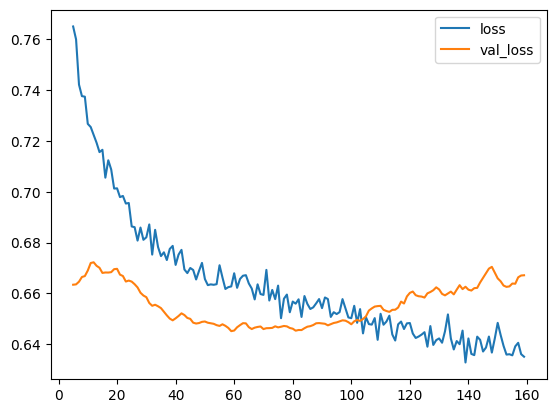

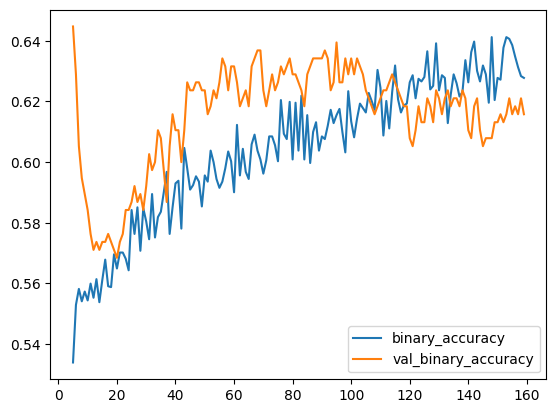

In [36]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

## Otimizacao

In [32]:
def f_treina_rede_parametros(quantidade_camadas, tamanho_camada, tamanho_batch, drop_out):
 
    if quantidade_camadas == 2:
        model = keras.Sequential([
            layers.BatchNormalization(input_shape=input_shape),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(1, activation='sigmoid'),
        ])
    elif quantidade_camadas == 3:
        model = keras.Sequential([
            layers.BatchNormalization(input_shape=input_shape),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(1, activation='sigmoid'),
        ])
    elif quantidade_camadas == 4:
        model = keras.Sequential([
            layers.BatchNormalization(input_shape=input_shape),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(1, activation='sigmoid'),
        ])
    elif quantidade_camadas == 5:
        model = keras.Sequential([
            layers.BatchNormalization(input_shape=input_shape),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(1, activation='sigmoid'),
        ])
    elif quantidade_camadas == 10:
        model = keras.Sequential([
            layers.BatchNormalization(input_shape=input_shape),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(tamanho_camada, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(drop_out),
            layers.Dense(1, activation='sigmoid'),
        ])


    early_stopping = keras.callbacks.EarlyStopping(
        patience=100,
        min_delta=0.001,
        restore_best_weights=True,
    )

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=tamanho_batch,
        epochs=2000,
        callbacks=[early_stopping],
        verbose=0
    )

    history_df = pd.DataFrame(history.history)
    # Start the plot at epoch 5
    history_df.loc[5:, ['loss', 'val_loss']].plot()
    history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

    print(("Best Validation Loss: {:0.4f}" +\
          "\nBest Validation Accuracy: {:0.4f}")\
          .format(history_df['val_loss'].min(), 
                  history_df['val_binary_accuracy'].max()))

    return round(history_df['val_binary_accuracy'].max(),4)

In [42]:
quantidade_camadas = 2
tamanho_camada = 64
tamanho_batch = 512
drop_out = 0.3

exp_quantidade_camadas = [3, 4, 5, 10]
exp_tamanho_camada = [64, 128, 256, 512, 1024]
exp_tamanho_batch = [128, 256, 512, 1024]
exp_drop_out = [0.1, 0.3, 0.5]

lista_resultados = []
iter = 0
melhor_acuracia = 0
for quantidade_camadas in exp_quantidade_camadas:
    for tamanho_camada in exp_tamanho_camada:
        for tamanho_batch in exp_tamanho_batch:
            for drop_out in exp_drop_out:

                acuracia = f_treina_rede_parametros(quantidade_camadas = quantidade_camadas, 
                                                    tamanho_camada = tamanho_camada, 
                                                    tamanho_batch = tamanho_batch, 
                                                    drop_out = drop_out)
                
                resumo = [quantidade_camadas, tamanho_camada, tamanho_batch, drop_out, acuracia]
                lista_resultados.append(resumo)
                iter = iter + 1
                if acuracia  > melhor_acuracia:
                    melhor_acuracia = acuracia
                print(f"{iter} - Set of parameters: quantidade_camadas: {quantidade_camadas}, tamanho_camada: {tamanho_camada}, tamanho_batch: {tamanho_batch}, drop_out={drop_out} ---> Acurácia = {acuracia} # Melhor Acurácia = {melhor_acuracia}")


1 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 128, drop_out=0.1 ---> Acurácia = 0.6289 # Melhor Acurácia = 0.6289
2 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 128, drop_out=0.3 ---> Acurácia = 0.6737 # Melhor Acurácia = 0.6737
3 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 128, drop_out=0.5 ---> Acurácia = 0.6684 # Melhor Acurácia = 0.6737
4 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 256, drop_out=0.1 ---> Acurácia = 0.6342 # Melhor Acurácia = 0.6737
5 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 256, drop_out=0.3 ---> Acurácia = 0.6421 # Melhor Acurácia = 0.6737
6 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 256, drop_out=0.5 ---> Acurácia = 0.6605 # Melhor Acurácia = 0.6737
7 - Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 512, drop_out=0.1 ---> Ac

: 

Best set of parameters:
Set of parameters: quantidade_camadas: 3, tamanho_camada: 64, tamanho_batch: 512, drop_out=0.5 ---> Acurácia = 0.6842 # Melhor Acurácia = 0.6842

2023-12-18 01:13:42.186107: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (100)


Best Validation Loss: 0.6404
Best Validation Accuracy: 0.6632


0.6632

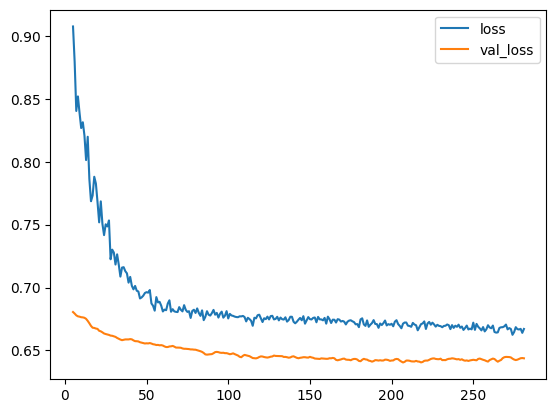

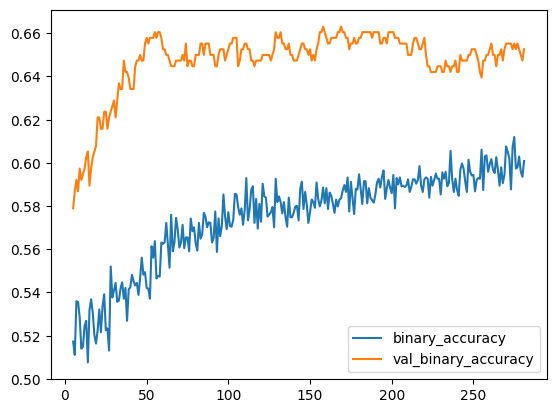

In [33]:
f_treina_rede_parametros(quantidade_camadas = 3, 
                                                    tamanho_camada = 64, 
                                                    tamanho_batch = 512, 
                                                    drop_out = 0.5)

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])


2023-12-18 01:21:33.038352: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (100)


In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=2000,
    callbacks=[early_stopping],
    verbose=0
)

Best Validation Loss: 0.6435
Best Validation Accuracy: 0.6526


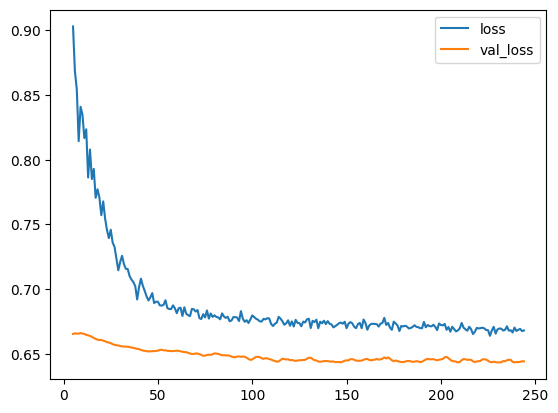

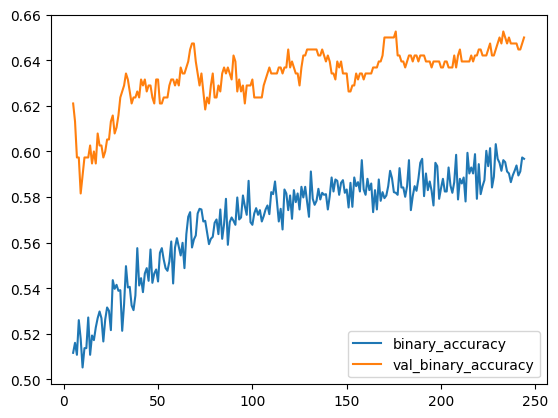

In [35]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [36]:
predicted_labels = model.predict(X_test)
predicted_labels

9/9 [==============================] - 0s 3ms/step


array([[0.5514838 ],
       [0.3593035 ],
       [0.46776843],
       [0.6108936 ],
       [0.5259012 ],
       [0.65117925],
       [0.5221646 ],
       [0.64372903],
       [0.41125837],
       [0.5550992 ],
       [0.41932815],
       [0.5500404 ],
       [0.48317868],
       [0.34288082],
       [0.39254   ],
       [0.40460438],
       [0.58182627],
       [0.53252715],
       [0.593864  ],
       [0.48180112],
       [0.29437947],
       [0.70255744],
       [0.5400973 ],
       [0.4375304 ],
       [0.43989593],
       [0.38318533],
       [0.47088057],
       [0.59907   ],
       [0.63962275],
       [0.514508  ],
       [0.5412605 ],
       [0.40319997],
       [0.6372014 ],
       [0.4646039 ],
       [0.45177317],
       [0.6325861 ],
       [0.40712827],
       [0.6293383 ],
       [0.45348933],
       [0.50786465],
       [0.5833943 ],
       [0.52076876],
       [0.5399597 ],
       [0.37419206],
       [0.5265124 ],
       [0.61303264],
       [0.36726075],
       [0.547

In [38]:
from sklearn.metrics import mean_absolute_error, accuracy_score

accuracy_score(y_test, predicted_labels)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

9/9 [==============================] - 0s 2ms/step


array([[0.46504256],
       [0.37370437],
       [0.518493  ],
       [0.56177294],
       [0.5024161 ],
       [0.6621375 ],
       [0.59342897],
       [0.67945915],
       [0.37733757],
       [0.5668113 ],
       [0.40757945],
       [0.5258252 ],
       [0.45511454],
       [0.3773456 ],
       [0.42248935],
       [0.45140827],
       [0.6514311 ],
       [0.5656108 ],
       [0.62481   ],
       [0.4721485 ],
       [0.29134643],
       [0.7464933 ],
       [0.59057164],
       [0.4672441 ],
       [0.43077326],
       [0.3726678 ],
       [0.5156049 ],
       [0.5325792 ],
       [0.65878946],
       [0.46256772],
       [0.5793345 ],
       [0.432934  ],
       [0.66448116],
       [0.45502314],
       [0.4402458 ],
       [0.67031145],
       [0.39252254],
       [0.64417547],
       [0.4638662 ],
       [0.44572616],
       [0.5576692 ],
       [0.56067175],
       [0.46686393],
       [0.37111747],
       [0.51530254],
       [0.6558706 ],
       [0.35528386],
       [0.521

In [56]:
predicted_labels = model.predict_classes(X_test)
predicted_labels

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [58]:
# make a prediction
ynew = model.predict_classes(X_test)
# show the inputs and predicted outputs
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [44]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    accuracy_score,
    roc_curve,
    roc_auc_score,
)

In [45]:
print(classification_report(y_test, predicted_labels))

ValueError: Classification metrics can't handle a mix of binary and continuous targets